In [1]:
from pathlib import Path
from rdkit import Chem
from iotbx.data_manager import DataManager
import numpy as np
import sys
import tqdm
from multiprocessing import Pool
from contextlib import closing
sys.path.append("..")

from phenixml.fragmentation.fragments import MolContainer, Fragment
from phenixml.fragmentation.fragmenters import MoleculeFragmenter, BondFragmenter, AngleFragmenter
from phenixml.featurizers.fragments.fingerprints import MorganFeaturizer, RDKFingerprint
from phenixml.labelers.fragment_labelers import BondFragmentLabeler, AngleFragmentLabeler
from phenixml.featurizers.fragments.ani_featurizer import ANIFeaturizer

from phenixml.fragments.nn_fragments import FragmentKNN
from phenixml.fragmentation.display import FragmentDisplay
display = FragmentDisplay()

In [2]:
# get molecules
mol_dir = "/dev/shm/cschlick/geostd_passed/"
containers = MolContainer.from_folder(mol_dir,max_files=None)

In [3]:
%%time
# Fragment and featurize

def worker(container):
  fragmenter = BondFragmenter(exclude_elements=["H"])
  fragments = fragmenter(container)
  try:
    features = ANIFeaturizer.from_fragments_midpoint(fragments)
    return (fragments,features)
  except:
    return None

work = containers
results = []
with closing(Pool(processes=64)) as pool:
  for result in tqdm.tqdm(pool.imap_unordered(worker, work), total=len(work)):
      results.append(result)
  pool.terminate()

  
fragments = []
features = []
for result in results:
  if result is not None:
    fragments+= result[0]
    features.append(result[1])
features = np.vstack(features)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16150/16150 [00:50<00:00, 321.50it/s]


CPU times: user 46 s, sys: 13.6 s, total: 59.6 s
Wall time: 53.3 s


In [4]:
%%time
# label the fragments
labeler = BondFragmentLabeler()
labels = labeler(fragments)

CPU times: user 14.5 s, sys: 105 ms, total: 14.6 s
Wall time: 14.6 s


In [25]:
# train/test split
from sklearn.model_selection import train_test_split
inds = np.arange(len(fragments))
train,test = train_test_split(inds,test_size=0.2)
feat_train, feat_test = features[train], features[test]
labels_train, labels_test = labels[train], labels[test]
frags_train = [fragments[i] for i in train]
frags_test = [fragments[i] for i in test]

## kNN

In [ ]:
%%time
knn = FragmentKNN(frags_train,features)

In [ ]:
nbrs,inds = knn.query(frags_test,k=20)

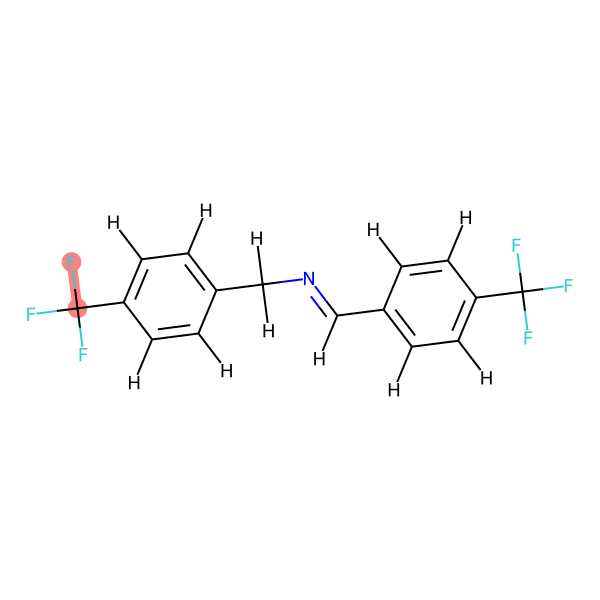

In [11]:
query_idx = 100
query_frag = fragments[query_idx]
query_feature = features[query_idx]
display(query_frag)

In [18]:
nbr_frags,inds = knn.query(query_feature,k=10,return_ind=True)

In [14]:
nbr_frags = nbr_frags

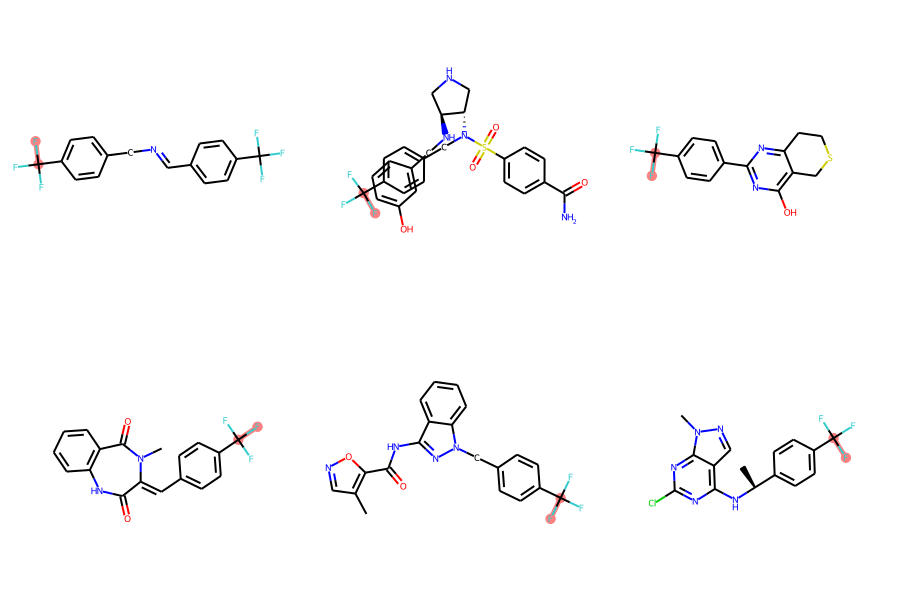

In [24]:
display(nbr_frags)

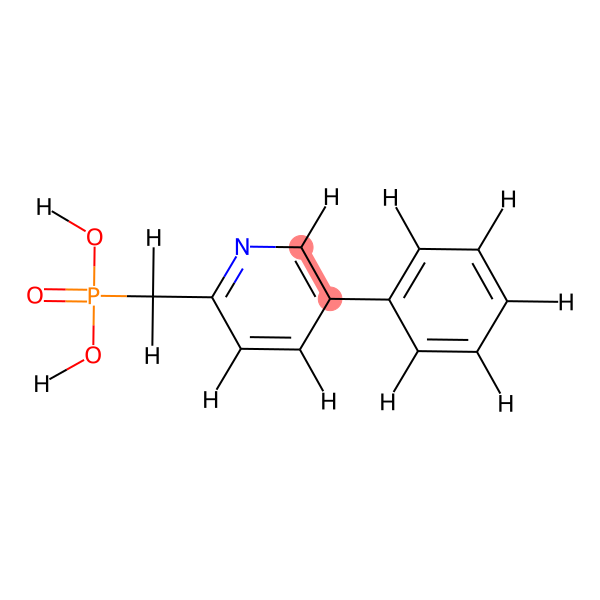

In [24]:
display(frags_test[3],)

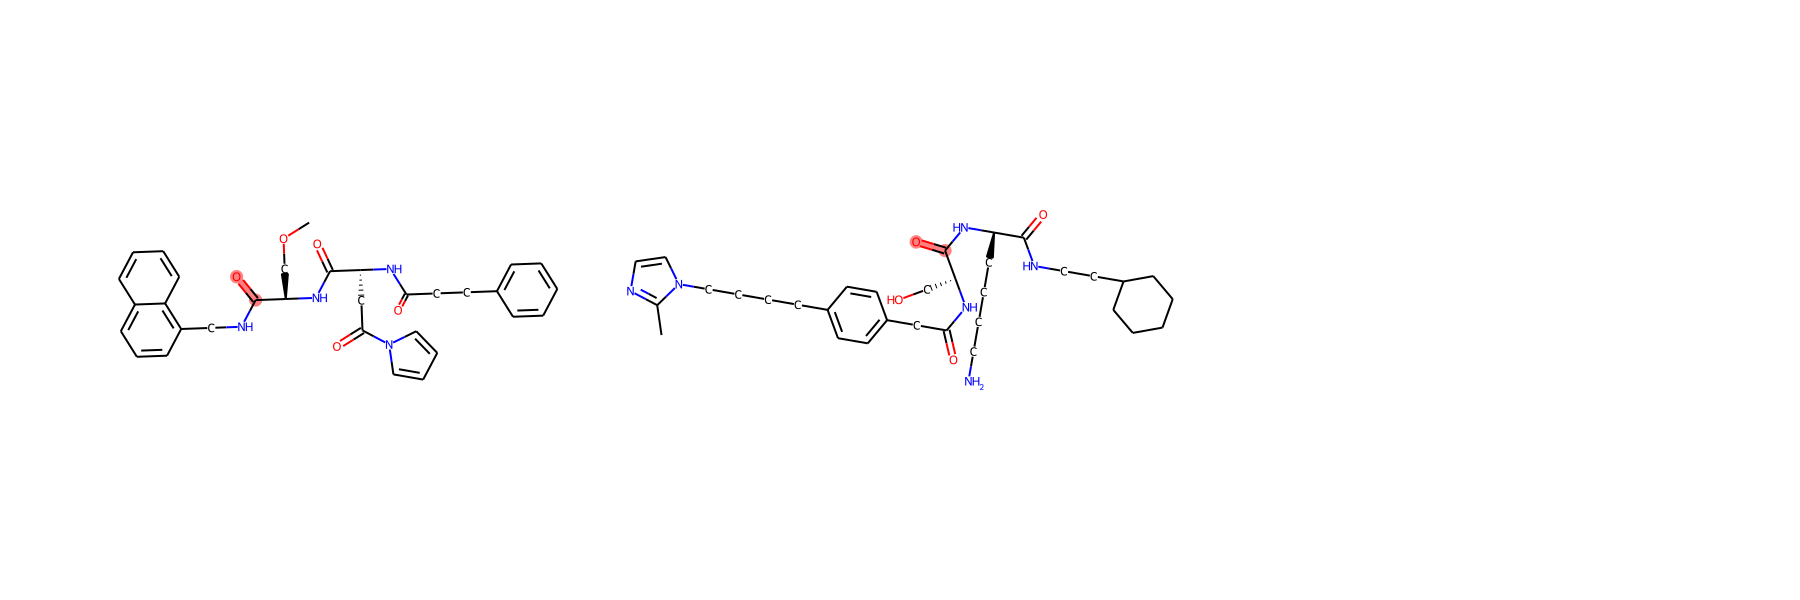

In [30]:
display(nbr_frags[0][0:2],subImgSize=(600,600))

## MLP Regression

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor


In [18]:
model = MLPRegressor(hidden_layer_sizes=(512,128))

In [ ]:
%%time
_ = model.fit(X_train,y_train)

In [ ]:
modelnn = 

# Angles

In [ ]:
# Fragment on angles
fragmenter = AngleFragmenter(exclude_elements=["H"])
fragments = fragmenter(containers)

In [ ]:
%%time
# Featurize the fragments
featurizer = MorganFeaturizer(nBits=1024)
features = featurizer.featurize(fragments,nproc=32)

In [ ]:
# label the fragments
labeler = AngleFragmentLabeler()
labels = labeler(fragments)

## kNN

## MLP Regression